# **Reinforcement Learning Project**

In [ ]:
!pip install pettingzoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 43.3 MB/s eta 0:00:00


In [ ]:
from pettingzoo.classic import connect_four_v3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [ ]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


## Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [ ]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [ ]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


## Running a game


The following function runs a full game between the two agents. 

In [ ]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

## Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [ ]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

## Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [ ]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

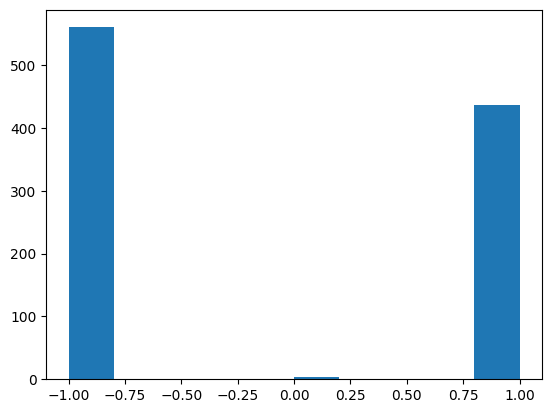

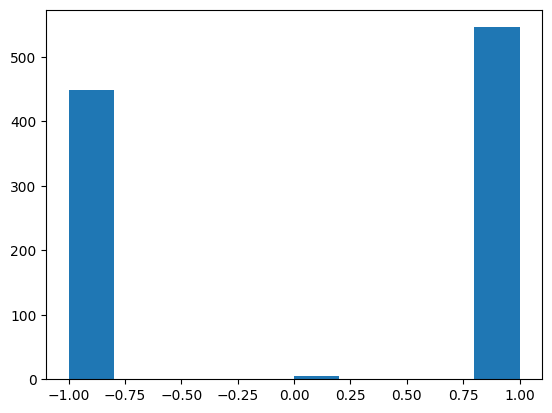

In [ ]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn : Q-Learning

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).

In the following section, we focus on the standard Q-Learning method (Tabular Refinforcement Learning). 

In [ ]:
# Additional imports
from collections import defaultdict
from tqdm import tqdm
import time

## Implementation of the agent

We implement here the Q-Learning agent class.

In [ ]:
class QLearner(): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self, 
                 action_space, 
                 observation_space, 
                 gamma=0.99, 
                 lr=0.1,
                 eps_init=.5, 
                 eps_min=1e-5,
                 eps_step=1e-3,
                 name='Q-learning'):
        
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.lr = lr
        self.rng = np.random.default_rng()
        
        self.eps_init = eps_init
        self.eps_min = eps_min
        self.eps_step = eps_step

        self.name = name
        
        self.reset()
    
    def eps_greedy(self, obs, eps=None):
        if eps is None: 
            eps = self.eps

        if np.random.random() < eps: 
            return self.random_choice_with_mask(np.arange(7), obs["action_mask"])
        else:
            h_obs = hashable_obs(obs)
            b = self.q_values[h_obs]
            b[obs["action_mask"] == 0] = -1
            return np.random.choice(np.flatnonzero(b == np.max(b))) # argmax with random tie-breaking
            #return np.argmax(b)

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())
        
    def get_action(self, obs, epsilon=None):
        return self.eps_greedy(obs, eps=epsilon)
        
    def update(self, obs, action, reward, terminated, next_obs):
        # update the q-values

        h_next_obs = hashable_obs(next_obs)
        estimate_value_at_next_state = (not terminated) * np.max(self.q_values[h_next_obs])
        new_estimate = reward + self.gamma * estimate_value_at_next_state
        
        h_obs = hashable_obs(obs)
        h_action = hashable_action(action)
        self.q_values[h_obs][h_action] = (
            (1 - self.lr) * self.q_values[h_obs][h_action] 
            + self.lr * new_estimate
        )
        
        self.epsilon_decay()
        
    def epsilon_decay(self):
        self.eps = max(self.eps - self.eps_step, self.eps_min)
        
    def reset(self):
        self.eps = self.eps_init
        self.q_values = defaultdict(lambda: np.zeros(7))

def hashable_obs(obs):
    return (obs['observation'][:, :, 0]- obs['observation'][:, :, 1]).tobytes()
  
def hashable_action(action):
    return int(action)

## Utilities functions

### Evaluation

For all our next experiments, we will evaluate the agents with the same method so that our results can be compared. For this purpose, the agent runs N games against an agent of the class RandomPlayer, with 50% of the game in the first position and 50% in the second position. We are then interested in the proportion of games won by the tested agent, which we called "winning rate".

In [ ]:
def evaluate(env, agent, N_episodes=1000):
    rnd_player = RandomPlayer()
    res = eval_against_policy(env, agent, rnd_player, N_episodes=N_episodes//2, first_player=False)
    res += eval_against_policy(env, agent, rnd_player, N_episodes=N_episodes//2, first_player=True)
    values, counts = np.unique(res, return_counts=True)
    res = {v: c for v, c in zip(values, counts)}
    return res[1] / N_episodes

### Training

The training is done against an agent of the class RandomPlayer.

In [ ]:
def run_N_episodes(env, agent, policy, N_episodes=1, first_player=True):
    train_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    # results = []
    for _ in range(N_episodes):
        done = False
        train_env.reset()
        obs, _, _, _, _ = train_env.last()
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = train_env.step(action)
            agent.update(obs, action, reward, terminated, next_obs)
            done = terminated or truncated
            obs = next_obs
    return agent

In [ ]:
def train_against_random(env, agent, N_episodes_train, nb_eval, N_episodes_eval):
    res = [evaluate(env, agent, N_episodes_eval)]
    rnd_player = RandomPlayer()
    for i in tqdm(range(nb_eval)):
        run_N_episodes(env, agent, rnd_player, N_episodes_train // (2 * nb_eval), True)
        run_N_episodes(env, agent, rnd_player, N_episodes_train // (2 * nb_eval), False)
        res.append(evaluate(env, agent, N_episodes_eval))
    return res

### Plot

It allows to plot the evolution of the winning rate while training. It can be used with agents with different parameters to compare them (see experiments). 

In [ ]:
def plot(res_dict, N_episodes_train, nb_eval, title=""):
    x = [i * N_episodes_train // nb_eval for i in range(nb_eval + 1)]
    for key in res_dict:
        res = res_dict[key]
        plt.plot(x, res, label=key)

    plt.xlabel("Nb episodes")
    plt.ylabel("Winning rate")
    plt.ylim((0,1))
    plt.legend()
    plt.title(title)

## Experiments and Results

### First results

We first trained a Q-Learning agent with standard values for its hyperparameters, to verify everithing works well.

100%|██████████| 50/50 [08:58<00:00, 10.77s/it]


Training + evaluations time: 543.58
Maximum winning rate: 0.869
Nb states: 551121


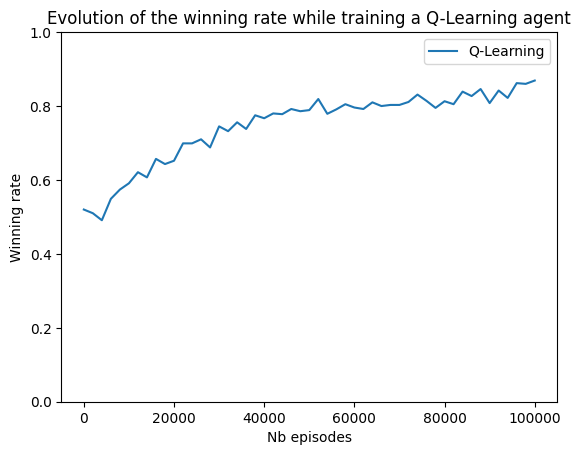

In [ ]:
def experience_test():
    # Eval parameters
    nb_eval = 50
    N_episodes_eval = 1000
    # Training parameters
    gamma = 0.9999
    lr = 0.1
    N_episodes = 100000
    eps_init = 1.0
    eps_min=1e-5
    eps_step=(eps_init - eps_min) / N_episodes

    # Standard training
    agent = QLearner(
        env.action_space,
        env.observation_space,
        gamma=gamma,
        lr=lr,
        eps_init=eps_init, 
        eps_min=eps_min,
        eps_step=eps_step
    )
    t0 = time.time()
    res = train_against_random(env, agent, N_episodes, nb_eval, N_episodes_eval)
    print(f"Training + evaluations time: {time.time() - t0:.2f}")
    plot({"Q-Learning": res}, N_episodes, nb_eval, "Evolution of the winning rate while training a Q-Learning agent")
    print(f"Maximum winning rate: {max(res)}")
    print(f"Nb states: {len(agent.q_values)}")
    

experience_test()

### Comparison between different initial epsilons

Here, we make `eps_init` vary.

100%|██████████| 50/50 [08:23<00:00, 10.06s/it]


Maximum winning rate:
{'eps_init = 0.25': 0.798, 'eps_init = 0.5': 0.836, 'eps_init = 0.75': 0.848, 'eps_init = 1.0': 0.886}


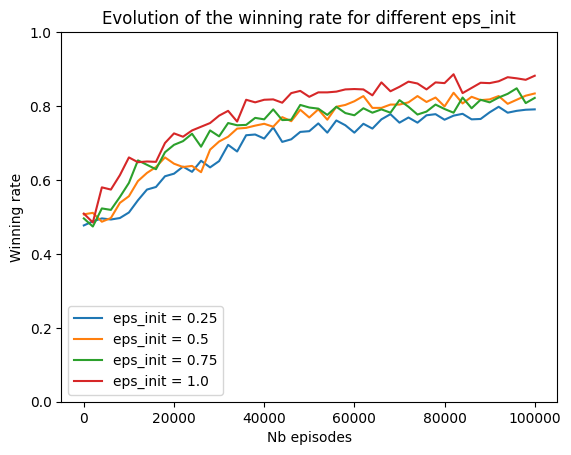

In [ ]:
def experience_eps_init():
    # Eval parameters
    nb_eval = 50
    N_episodes_eval = 1000
    # Training parameters
    lr = 0.1
    gamma = 0.9999
    N_episodes = 100000
    eps_min=1e-5
    
    res = {}
    for eps_init in [0.25, 0.5, 0.75, 1.0]:
        eps_step=(eps_init - eps_min) / N_episodes
        key = f"eps_init = {eps_init}"
        agent = QLearner(
            env.action_space,
            env.observation_space,
            gamma=gamma,
            lr=lr,
            eps_init=eps_init, 
            eps_min=eps_min,
            eps_step=eps_step
        )
        res[key] = train_against_random(env, agent, N_episodes, nb_eval, N_episodes_eval)
    
    plot(res, N_episodes, nb_eval, "Evolution of the winning rate for different eps_init")
    print("Maximum winning rate:")
    print({key: max(res[key]) for key in res})
    return res

res = experience_eps_init()

### Comparison between different learning rates

Here, we make `lr` vary.

100%|██████████| 50/50 [09:08<00:00, 10.97s/it]


Maximum winning rate:
{'lr = 0.05': 0.828, 'lr = 0.1': 0.796, 'lr = 0.25': 0.848, 'lr = 0.5': 0.846}


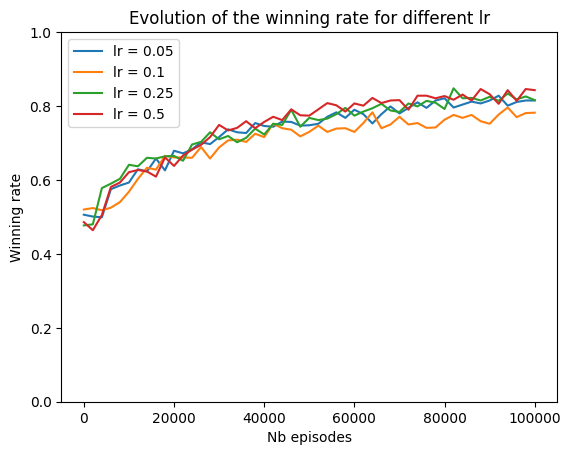

In [ ]:
def experience_lr():
    # Eval parameters
    nb_eval = 50
    N_episodes_eval = 1000
    # Training parameters
    gamma = 0.9999
    N_episodes = 100000
    eps_init = 1.0
    eps_min=1e-5
    eps_step=(eps_init - eps_min) / N_episodes
    
    res = {}
    for lr in [0.05, 0.1, 0.25, 0.5]:
        key = f"lr = {lr}"
        agent = QLearner(
            env.action_space,
            env.observation_space,
            gamma=gamma,
            lr=lr,
            eps_init=eps_init, 
            eps_min=eps_min,
            eps_step=eps_step
        )
        res[key] = train_against_random(env, agent, N_episodes, nb_eval, N_episodes_eval)
    
    plot(res, N_episodes, nb_eval, "Evolution of the winning rate for different lr")
    print("Maximum winning rate:")
    print({key: max(res[key]) for key in res})
    return res

res = experience_lr()

### Comparison between different gammas

Here, we make `gamma` vary.

100%|██████████| 50/50 [09:05<00:00, 10.92s/it]


Maximum winning rate:
{'gamma = 0.5': 0.815, 'gamma = 0.9': 0.84, 'gamma = 0.95': 0.876, 'gamma = 0.9999': 0.823}


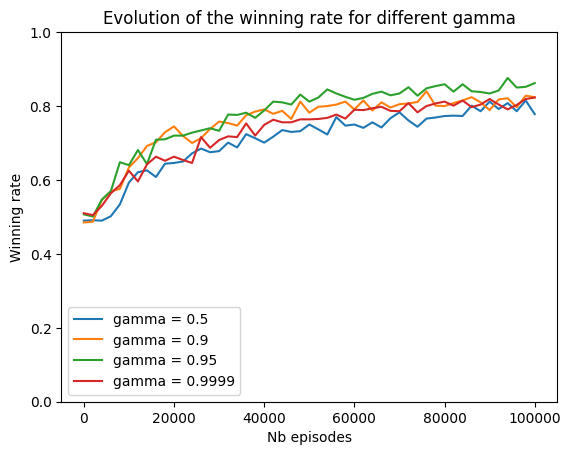

In [ ]:
def experience_gamma():
    # Eval parameters
    nb_eval = 50
    N_episodes_eval = 1000
    # Training parameters
    lr = 0.1
    N_episodes = 100000
    eps_init = 1.0
    eps_min=1e-5
    eps_step=(eps_init - eps_min) / N_episodes
    
    res = {}
    for gamma in [0.5, 0.9, 0.95, 0.9999]:
        key = f"gamma = {gamma}"
        agent = QLearner(
            env.action_space,
            env.observation_space,
            gamma=gamma,
            lr=lr,
            eps_init=eps_init, 
            eps_min=eps_min,
            eps_step=eps_step
        )
        res[key] = train_against_random(env, agent, N_episodes, nb_eval, N_episodes_eval)
    
    plot(res, N_episodes, nb_eval, "Evolution of the winning rate for different gamma")
    print("Maximum winning rate:")
    print({key: max(res[key]) for key in res})
    return res

res = experience_gamma()

### Comparison between different training processes

Here, we try another method of learning, where we train two Q-Learning agents alternatively. The idea is that an agent may learn better when trained against an agent that is getting better and better.

100%|██████████| 50/50 [42:57<00:00, 51.56s/it]


Maximum winning rate:
{'standard training': 0.789, 'in pair training': 0.648}


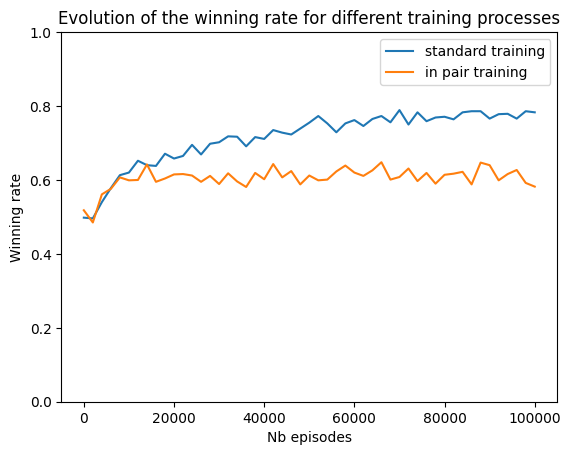

In [ ]:
def train_in_pair(env, agent1, agent2, N_episodes_train, nb_eval, N_episodes_eval):
    res1 = [evaluate(env, agent1, N_episodes_eval)]
    res2 = [evaluate(env, agent2, N_episodes_eval)]
    for i in tqdm(range(nb_eval)):
        # Train agent 1
        run_N_episodes(env, agent1, agent2, N_episodes_train // (2 * nb_eval), True)
        run_N_episodes(env, agent1, agent2, N_episodes_train // (2 * nb_eval), False)
        res1.append(evaluate(env, agent1, N_episodes_eval))
        # Train agent 2
        run_N_episodes(env, agent2, agent1, N_episodes_train // (2 * nb_eval), True)
        run_N_episodes(env, agent2, agent1, N_episodes_train // (2 * nb_eval), False)
        res2.append(evaluate(env, agent2, N_episodes_eval))
    return res1, res2

def experience_train_in_pair():
    # Eval parameters
    nb_eval = 50
    N_episodes_eval = 1000
    # Training parameters
    gamma = 0.9999
    lr = 0.1
    N_episodes = 100000
    eps_init = 1.0
    eps_min=1e-5
    eps_step=(eps_init - eps_min) / N_episodes
    
    res = {}
    # Standard training
    key = f"standard training"
    agent = QLearner(
        env.action_space,
        env.observation_space,
        gamma=gamma,
        lr=lr,
        eps_init=eps_init, 
        eps_min=eps_min,
        eps_step=eps_step
    )
    res[key] = train_against_random(env, agent, N_episodes, nb_eval, N_episodes_eval)
    # In pair training
    key = f"in pair training"
    agent1 = QLearner(
        env.action_space,
        env.observation_space,
        gamma=gamma,
        lr=lr,
        eps_init=eps_init, 
        eps_min=eps_min,
        eps_step=eps_step
    )
    agent2 = QLearner(
        env.action_space,
        env.observation_space,
        gamma=gamma,
        lr=lr,
        eps_init=eps_init, 
        eps_min=eps_min,
        eps_step=eps_step
    )
    res[key] = train_in_pair(env, agent1, agent2, N_episodes, nb_eval, N_episodes_eval)[0]

    
    plot(res, N_episodes, nb_eval, "Evolution of the winning rate for different training processes")
    print("Maximum winning rate:")
    print({key: max(res[key]) for key in res})
    return res

res = experience_train_in_pair()